In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import joblib

sns.set_style("whitegrid")


In [8]:
file_path = "../data/raw/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"

df = pd.read_csv(file_path)

# Limpar nomes das colunas
df.columns = df.columns.str.strip()

df.head()


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443,192.168.10.16,46236,6,7/7/2017 3:30,34,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443,192.168.10.5,54863,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [9]:
# Criar alvo binário: 1 para DDoS, 0 para BENIGN
df['target'] = (df['Label'] == 'DDoS').astype(int)

# Selecionar apenas colunas numéricas para features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Remover a coluna 'target' das features
numeric_cols = numeric_cols.drop('target')

X = df[numeric_cols]
y = df['target']

X.shape, y.shape


((225745, 80), (225745,))

In [10]:
# Substituir valores infinitos por NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Substituir NaN por 0
X = X.fillna(0)

# Verificar se ficou limpo
print("Valores infinitos após limpeza:", np.isinf(X).sum().sum())
print("Valores NaN após limpeza:", np.isnan(X).sum().sum())


Valores infinitos após limpeza: 0
Valores NaN após limpeza: 0


In [11]:
model_path = "../models/random_forest_ddos.pkl"

rf_clf = joblib.load(model_path)

rf_clf


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [13]:
# Gerar probabilidade de ser DDoS (classe 1)
y_proba = rf_clf.predict_proba(X)[:, 1]
df['ddos_proba'] = y_proba

def definir_prioridade(p):
    if p >= 0.95:
        return "ALTA"
    elif p >= 0.70:
        return "MEDIA"
    else:
        return "BAIXA"

df['prioridade'] = df['ddos_proba'].apply(definir_prioridade)

df[['Flow ID', 'Label', 'ddos_proba', 'prioridade']].head(10)


,Flow ID,Label,ddos_proba,prioridade
0,192.168.10.5-104.16.207.165-54865-443-6,BENIGN,0.0,BAIXA
1,192.168.10.5-104.16.28.216-55054-80-6,BENIGN,0.0,BAIXA
2,192.168.10.5-104.16.28.216-55055-80-6,BENIGN,0.0,BAIXA
3,192.168.10.16-104.17.241.25-46236-443-6,BENIGN,0.0,BAIXA
4,192.168.10.5-104.19.196.102-54863-443-6,BENIGN,0.0,BAIXA
5,192.168.10.5-104.20.10.120-54871-443-6,BENIGN,0.0,BAIXA
6,192.168.10.5-104.20.10.120-54925-443-6,BENIGN,0.0,BAIXA
7,192.168.10.5-104.20.10.120-54925-443-6,BENIGN,0.0,BAIXA
8,192.168.10.8-104.28.13.116-9282-443-6,BENIGN,0.0,BAIXA
9,192.168.10.5-104.97.123.193-55153-443-6,BENIGN,0.0,BAIXA


In [9]:
# Ver alguns fluxos marcados como DDoS e suas probabilidades/prioridades
df[df['Label'] == 'DDoS'][['Flow ID', 'Label', 'ddos_proba', 'prioridade']].head(10)


,Flow ID,Label,ddos_proba,prioridade
18883,172.16.0.1-192.168.10.50-49650-80-6,DDoS,1.0,ALTA
18884,172.16.0.1-192.168.10.50-49650-80-6,DDoS,1.0,ALTA
18885,172.16.0.1-192.168.10.50-51684-80-6,DDoS,1.0,ALTA
18886,172.16.0.1-192.168.10.50-51684-80-6,DDoS,1.0,ALTA
18887,172.16.0.1-192.168.10.50-51686-80-6,DDoS,1.0,ALTA
18888,172.16.0.1-192.168.10.50-51686-80-6,DDoS,1.0,ALTA
18889,172.16.0.1-192.168.10.50-51687-80-6,DDoS,1.0,ALTA
18890,172.16.0.1-192.168.10.50-51687-80-6,DDoS,1.0,ALTA
18891,172.16.0.1-192.168.10.50-51688-80-6,DDoS,1.0,ALTA
18892,172.16.0.1-192.168.10.50-51688-80-6,DDoS,1.0,ALTA


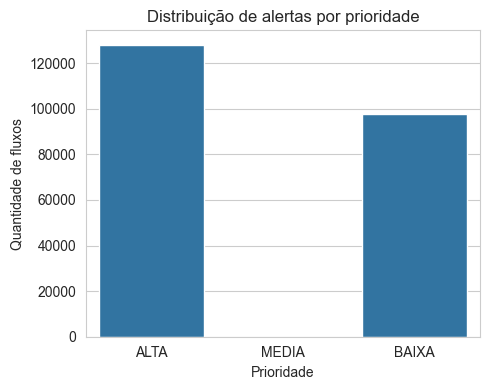

In [10]:
plt.figure(figsize=(5,4))
sns.countplot(x='prioridade', data=df,
              order=['ALTA', 'MEDIA', 'BAIXA'])
plt.title("Distribuição de alertas por prioridade")
plt.xlabel("Prioridade")
plt.ylabel("Quantidade de fluxos")
plt.tight_layout()
plt.show()


In [11]:
# Criar uma cópia só com as colunas mais úteis para o analista
colunas_alerta = [
    'Flow ID',
    'Label',
    'ddos_proba',
    'prioridade'
]

# Ordenar por: prioridade (ALTA > MEDIA > BAIXA) e probabilidade (decrescente)
prioridade_ordem = {'ALTA': 0, 'MEDIA': 1, 'BAIXA': 2}
df_alertas = df.copy()
df_alertas['prioridade_ordem'] = df_alertas['prioridade'].map(prioridade_ordem)

df_alertas = df_alertas.sort_values(
    by=['prioridade_ordem', 'ddos_proba'],
    ascending=[True, False]
)

# Mostrar o topo da fila de alertas (os mais críticos primeiro)
df_alertas[colunas_alerta].head(20)


,Flow ID,Label,ddos_proba,prioridade
18883,172.16.0.1-192.168.10.50-49650-80-6,DDoS,1.0,ALTA
18884,172.16.0.1-192.168.10.50-49650-80-6,DDoS,1.0,ALTA
18885,172.16.0.1-192.168.10.50-51684-80-6,DDoS,1.0,ALTA
18886,172.16.0.1-192.168.10.50-51684-80-6,DDoS,1.0,ALTA
18887,172.16.0.1-192.168.10.50-51686-80-6,DDoS,1.0,ALTA
18888,172.16.0.1-192.168.10.50-51686-80-6,DDoS,1.0,ALTA
18889,172.16.0.1-192.168.10.50-51687-80-6,DDoS,1.0,ALTA
18890,172.16.0.1-192.168.10.50-51687-80-6,DDoS,1.0,ALTA
18891,172.16.0.1-192.168.10.50-51688-80-6,DDoS,1.0,ALTA
18892,172.16.0.1-192.168.10.50-51688-80-6,DDoS,1.0,ALTA


In [14]:
# Colunas úteis para o analista de SOC
colunas_alerta = [
    'Flow ID',
    'Source IP',
    'Destination IP',
    'Source Port',
    'Destination Port',
    'Protocol',
    'Label',        # no mundo real você não teria isso, é só para validação
    'ddos_proba',
    'prioridade'
]

# Garantir que só usamos colunas que existem
colunas_existentes = [c for c in colunas_alerta if c in df.columns]

df_alertas = df[colunas_existentes].copy()

df_alertas.head(10)


,Flow ID,Source IP,Destination IP,Source Port,Destination Port,Protocol,Label,ddos_proba,prioridade
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,192.168.10.5,443,54865,6,BENIGN,0.0,BAIXA
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,192.168.10.5,80,55054,6,BENIGN,0.0,BAIXA
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,192.168.10.5,80,55055,6,BENIGN,0.0,BAIXA
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,192.168.10.16,443,46236,6,BENIGN,0.0,BAIXA
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,192.168.10.5,443,54863,6,BENIGN,0.0,BAIXA
5,192.168.10.5-104.20.10.120-54871-443-6,104.20.10.120,192.168.10.5,443,54871,6,BENIGN,0.0,BAIXA
6,192.168.10.5-104.20.10.120-54925-443-6,104.20.10.120,192.168.10.5,443,54925,6,BENIGN,0.0,BAIXA
7,192.168.10.5-104.20.10.120-54925-443-6,104.20.10.120,192.168.10.5,443,54925,6,BENIGN,0.0,BAIXA
8,192.168.10.8-104.28.13.116-9282-443-6,104.28.13.116,192.168.10.8,443,9282,6,BENIGN,0.0,BAIXA
9,192.168.10.5-104.97.123.193-55153-443-6,104.97.123.193,192.168.10.5,443,55153,6,BENIGN,0.0,BAIXA


In [15]:
# Mapa para ordenar as prioridades
prioridade_ordem = {'ALTA': 0, 'MEDIA': 1, 'BAIXA': 2}

# Criar coluna auxiliar com valor numérico da prioridade
df_alertas['prioridade_ordem'] = df_alertas['prioridade'].map(prioridade_ordem)

# Ordenar: primeiro prioridade (ALTA > MEDIA > BAIXA), depois probabilidade decrescente
df_alertas_sorted = df_alertas.sort_values(
    by=['prioridade_ordem', 'ddos_proba'],
    ascending=[True, False]
)

# Remover coluna auxiliar da visualização
df_alertas_sorted = df_alertas_sorted.drop(columns=['prioridade_ordem'])

# Mostrar o topo da fila de alertas (mais críticos primeiro)
df_alertas_sorted.head(20)


,Flow ID,Source IP,Destination IP,Source Port,Destination Port,Protocol,Label,ddos_proba,prioridade
18883,172.16.0.1-192.168.10.50-49650-80-6,172.16.0.1,192.168.10.50,49650,80,6,DDoS,1.0,ALTA
18884,172.16.0.1-192.168.10.50-49650-80-6,172.16.0.1,192.168.10.50,49650,80,6,DDoS,1.0,ALTA
18885,172.16.0.1-192.168.10.50-51684-80-6,172.16.0.1,192.168.10.50,51684,80,6,DDoS,1.0,ALTA
18886,172.16.0.1-192.168.10.50-51684-80-6,172.16.0.1,192.168.10.50,51684,80,6,DDoS,1.0,ALTA
18887,172.16.0.1-192.168.10.50-51686-80-6,172.16.0.1,192.168.10.50,51686,80,6,DDoS,1.0,ALTA
18888,172.16.0.1-192.168.10.50-51686-80-6,172.16.0.1,192.168.10.50,51686,80,6,DDoS,1.0,ALTA
18889,172.16.0.1-192.168.10.50-51687-80-6,172.16.0.1,192.168.10.50,51687,80,6,DDoS,1.0,ALTA
18890,172.16.0.1-192.168.10.50-51687-80-6,172.16.0.1,192.168.10.50,51687,80,6,DDoS,1.0,ALTA
18891,172.16.0.1-192.168.10.50-51688-80-6,172.16.0.1,192.168.10.50,51688,80,6,DDoS,1.0,ALTA
18892,172.16.0.1-192.168.10.50-51688-80-6,172.16.0.1,192.168.10.50,51688,80,6,DDoS,1.0,ALTA


In [16]:
print("=" * 60)
print("RESUMO DA PRIORIZAÇÃO DE ALERTAS")
print("=" * 60)

# 1) Distribuição geral por prioridade
print("\n1) Distribuição de fluxos por prioridade:")
print(df_alertas['prioridade'].value_counts().sort_index())

# 2) Quantos DDoS reais em cada prioridade
print("\n2) Fluxos DDoS reais por prioridade:")
ddos_por_prioridade = df_alertas[df_alertas['Label'] == 'DDoS']['prioridade'].value_counts().sort_index()
print(ddos_por_prioridade)

# 3) Quantos BENIGN em cada prioridade
print("\n3) Fluxos BENIGN por prioridade:")
benign_por_prioridade = df_alertas[df_alertas['Label'] == 'BENIGN']['prioridade'].value_counts().sort_index()
print(benign_por_prioridade)

# 4) Taxa de acerto na prioridade ALTA (quantos % dos ALTA são realmente DDoS)
alta = df_alertas[df_alertas['prioridade'] == 'ALTA']
if len(alta) > 0:
    taxa_acerto_alta = (alta['Label'] == 'DDoS').sum() / len(alta) * 100
    print(f"\n4) Taxa de acerto em prioridade ALTA: {taxa_acerto_alta:.2f}%")
    print(f"   (dos {len(alta)} alertas ALTA, {(alta['Label'] == 'DDoS').sum()} são DDoS reais)")
else:
    print("\n4) Nenhum alerta com prioridade ALTA.")

print("\n" + "=" * 60)


RESUMO DA PRIORIZAÇÃO DE ALERTAS

1) Distribuição de fluxos por prioridade:
prioridade
ALTA     127942
BAIXA     97729
MEDIA        74
Name: count, dtype: int64

2) Fluxos DDoS reais por prioridade:
prioridade
ALTA     127942
BAIXA        11
MEDIA        74
Name: count, dtype: int64

3) Fluxos BENIGN por prioridade:
prioridade
BAIXA    97718
Name: count, dtype: int64

4) Taxa de acerto em prioridade ALTA: 100.00%
   (dos 127942 alertas ALTA, 127942 são DDoS reais)



In [17]:
# Salvar a fila de alertas priorizada em CSV
output_path = "../data/ddos_alerts_prioritized.csv"

df_alertas_sorted.to_csv(output_path, index=False)

print(f"Fila de alertas salva em: {output_path}")
print(f"Total de alertas exportados: {len(df_alertas_sorted)}")


Fila de alertas salva em: ../data/ddos_alerts_prioritized.csv
Total de alertas exportados: 225745


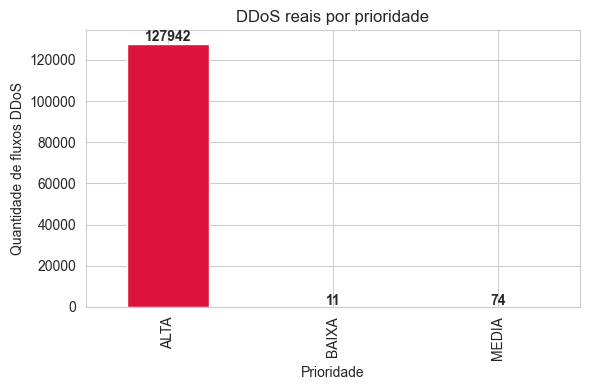

In [19]:
import matplotlib.pyplot as plt

# Filtrar só os DDoS reais
ddos = df_alertas[df_alertas['Label'] == 'DDoS']

# Contar quantos DDoS em cada prioridade
contagem = ddos['prioridade'].value_counts().sort_index()

# Criar o gráfico
ax = contagem.plot(kind='bar', color='crimson', figsize=(6,4))

plt.title("DDoS reais por prioridade")
plt.xlabel("Prioridade")
plt.ylabel("Quantidade de fluxos DDoS")

# Adicionar os valores em cima de cada barra
for i, v in enumerate(contagem):
    ax.text(i, v + 1000, str(v), ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()
